In [ ]:
pip install datasets==1.3.0

     |████████████████████████████████| 184kB 6.5MB/s 
     |████████████████████████████████| 245kB 7.1MB/s 
     |████████████████████████████████| 112kB 10.7MB/s 


In [ ]:
pip install transformers==4.3.2

     |████████████████████████████████| 1.8MB 6.4MB/s 
     |████████████████████████████████| 3.2MB 21.3MB/s 
     |████████████████████████████████| 890kB 41.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=12b6c8a8992aea61e14ef5f9534079dad00e30edfe6d5c33e217cbf7d1574012
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# specify GPU device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P4'

In [ ]:
pip install numpy==1.20.1

     |████████████████████████████████| 15.3MB 213kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.1 which is incompatible.
ERROR: jaxlib 0.1.60+cuda101 has requirement numpy<1.20,>=1.12, but you'll have numpy 1.20.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [ ]:
from datasets import load_dataset
emotions_dataset = load_dataset('go_emotions', 'simplified')

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e. Subsequent calls will reuse this data.


In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
# For simplicity, train model with single label for item.
restricted_dataset = emotions_dataset.filter(lambda x: len(x["labels"]) == 1 and 27 not in x['labels'])
print(len(restricted_dataset['train']))
#show_random_elements(restricted_dataset['train'])


23485


In [ ]:
labels = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", 
          "confusion", "curiosity", "desire", "disappointment", "disapproval",
          "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
          "joy", "love", "nervousness", "optimism", "pride", "realization",
          "relief", "remorse", "sadness", "surprise", "neutral"]
index_to_labels = {index: label for index, label in enumerate(labels)}
  

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer

model_name = 'distilbert-base-uncased'
config = AutoConfig.from_pretrained(model_name, num_labels=27)
model = AutoModelForSequenceClassification.from_config(config=config)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [ ]:
global tokenizer
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

def convert_labels_to_int(example):
    example['labels'] = example['labels'][0]
    return example


In [ ]:
metric = datasets.load_metric('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
import numpy as np
from transformers import Trainer, TrainingArguments
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer


def build_and_evaluate_model(learning_rate, train_batch, eval_batch, epochs, weight, model_name): 

  model_name = model_name
  config = AutoConfig.from_pretrained(model_name, num_labels=27)
  model = AutoModelForSequenceClassification.from_config(config=config)
  tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
  
  encoded_dataset = restricted_dataset.map(preprocess_function, batched=True)
  encoded_dataset = encoded_dataset.map(convert_labels_to_int)

  metric_name = "accuracy"


  args = TrainingArguments(
      "test-emotions",
      evaluation_strategy = "epoch",
      learning_rate=learning_rate,
      per_device_train_batch_size=train_batch,
      per_device_eval_batch_size=eval_batch,
      num_train_epochs=epochs,
      weight_decay=weight,
      load_best_model_at_end=True,
      metric_for_best_model=metric_name,
  )

  validation_key = "validation"
  trainer = Trainer(
      model,
      args,
      train_dataset=encoded_dataset["train"],
      eval_dataset=encoded_dataset["validation"],
      tokenizer=tokenizer,
      compute_metrics=compute_metrics
  )

  print("Model is training ........")
  trainer.train()
  trainer.evaluate

## DistillBert Model

In [ ]:
build_and_evaluate_model(2e-5, 32, 32, 5, 0.01, 'distilbert-base-uncased')


Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.572700,1.802139,0.515223,3.429700,861.882000
2,1.886500,1.652027,0.541272,3.528800,837.672000
3,1.491600,1.544248,0.563261,3.534700,836.279000


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.572700,1.802139,0.515223,3.429700,861.882000
2,1.886500,1.652027,0.541272,3.528800,837.672000
3,1.491600,1.544248,0.563261,3.534700,836.279000
4,1.389900,1.532073,0.576116,3.532800,836.719000
5,1.235800,1.517607,0.578484,3.524100,838.802000


In [ ]:
build_and_evaluate_model(2e-3, 32, 32, 2, 0.02, 'distilbert-base-uncased')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-62400783547038d2.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-339a4f36e1da0d6d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-1bffc079ad09b3c9.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-ff1217bc7f62ea0c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-ff24aabc11c5d855.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,3.055000,3.021182,0.110284,3.095000,955.078000
2,3.019600,3.002506,0.110284,3.103300,952.543000


In [ ]:
build_and_evaluate_model(2e-3, 64, 64, 2, 0.001, 'distilbert-base-uncased')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-62400783547038d2.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-339a4f36e1da0d6d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-1bffc079ad09b3c9.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-ff1217bc7f62ea0c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-ff24aabc11c5d855.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,No log,3.004826,0.110284,3.258200,907.242000
2,3.038000,3.002138,0.110284,3.265500,905.220000


##Bert Model

In [ ]:
build_and_evaluate_model(2e-5, 32, 32, 5, 0.01, 'bert-base-uncased')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-62400783547038d2.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-339a4f36e1da0d6d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-1bffc079ad09b3c9.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-ff1217bc7f62ea0c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-ff24aabc11c5d855.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.634300,1.936160,0.476658,6.529500,452.717000
2,2.008000,1.690170,0.537889,6.526600,452.917000
3,1.559700,1.575171,0.569012,6.535800,452.278000
4,1.432900,1.560175,0.570027,6.526200,452.943000
5,1.266700,1.529667,0.577808,6.508800,454.157000


In [ ]:
build_and_evaluate_model(2e-3, 32, 32, 2, 0.02, 'bert-base-uncased')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-62400783547038d2.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-339a4f36e1da0d6d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-1bffc079ad09b3c9.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-ff1217bc7f62ea0c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-ff24aabc11c5d855.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,3.278800,3.191662,0.070365,6.074700,486.610000
2,3.157700,3.006388,0.110284,6.075500,486.542000


In [ ]:
build_and_evaluate_model(2e-3, 64, 64, 2, 0.001, 'bert-base-uncased')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-62400783547038d2.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-339a4f36e1da0d6d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-1bffc079ad09b3c9.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-ff1217bc7f62ea0c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-ff24aabc11c5d855.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,No log,3.095609,0.071719,6.248800,473.054000
2,3.168700,3.009229,0.110284,6.248100,473.101000


##Albert Model

In [ ]:
build_and_evaluate_model(2e-5, 32, 32, 2, 0.01, 'albert-base-v2')


Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.690400,2.169227,0.408660,7.212000,409.874000
2,2.195000,2.000359,0.455345,7.200000,410.556000


In [ ]:
build_and_evaluate_model(2e-3, 32, 32, 2, 0.02, 'albert-base-v2')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-99e2e3051dd8613c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-4786ddc014d62ee3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-1e69ae1ddd7d7836.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-483f40e8a1b92bad.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-a2c3dff41d711486.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,3.294500,3.196371,0.070365,6.863500,430.687000
2,3.156500,3.006661,0.110284,6.852400,431.384000



# Automatic Hyperaparameter Tunning

In [ ]:
pip install optuna

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=27)

In [ ]:
validation_key = "validation"
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=2) 

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=2, direction="maximize")

In [ ]:
best_run

In [ ]:
import numpy as np

mytrainer = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.663100,2.026286,0.437077,6.552700,451.108000
2,2.093700,1.783051,0.518268,6.568300,450.038000


In [ ]:

evalValue = trainer.evaluate()


In [ ]:
for key, value in evalValue.items():
	    print("{}: {}".format(key, value))

eval_loss: 1.783050775527954
eval_accuracy: 0.5182679296346414
eval_runtime: 6.3931
eval_samples_per_second: 462.372
epoch: 2.0


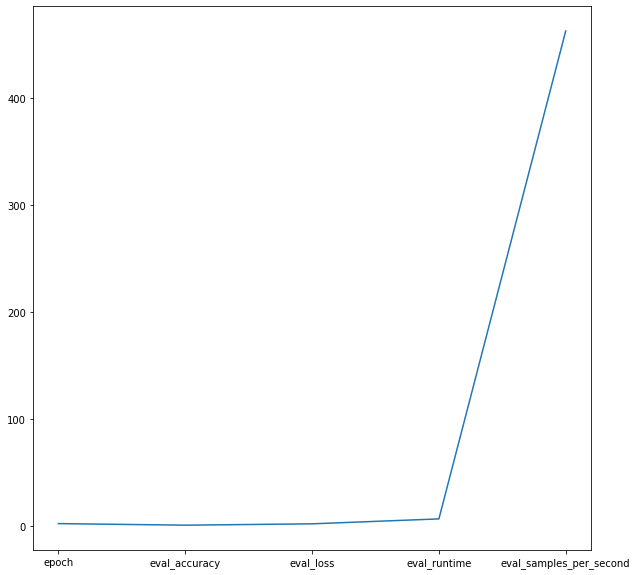

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(*zip(*sorted(evalValue.items())))
plt.show()

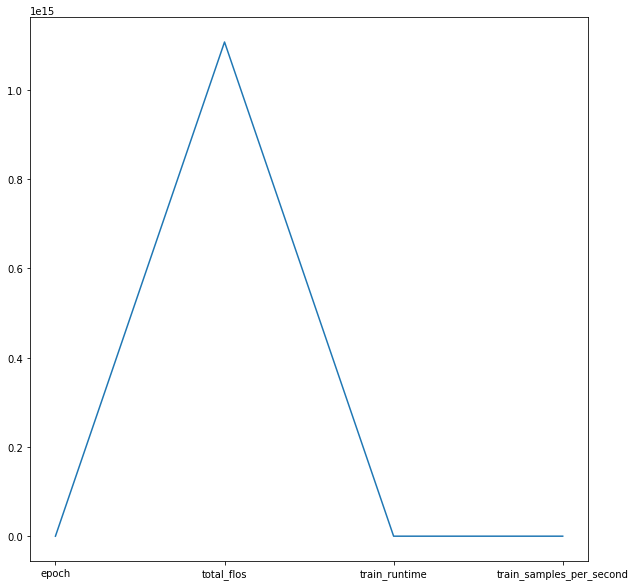

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(*zip(*sorted(mytrainer.metrics.items())))
plt.show()

# Your work

Qs 1. Can you report how accuracy changes with varying the hypyerparameters defined above? How does accuracy change with increasing number of epochs? Learning rate? Mention your final choice of parameters and graph how they impact accuracy. 

Qs 2. Try any 2 other models for sequence classification supported by Huggingface and repeat Qs 1 for these. You can find a full list of these [here](https://huggingface.co/transformers/model_doc/auto.html#automodelforsequenceclassification). (For those of you working with text for your project, you may also find several other useful models for Seq2Seq modeling, question answering, etc.)

Qs 3. Wrangle / change the data so that you can instead build a "positive" emotion vs "negative" emotions classifier, by combining labels. Can you now report the accuracy of a classifer on this data? You may use one of the model architectures from (1) or (2)

Qs 4. Export models from qs 1 and 3, and build a FastAPI around it, as discussed in class, which returns the most likely emotion found. (You may need to look up Huggingface documentation on how to save and load models). In particular, you should support two API endpoints - "detect_emotion_binary" and "detect_emotion_full" which supports each model.

Qs 5. Finally, can you dockerize this? You do NOT need to deploy this to the cloud.

Submission instructions: Zip your compiled .ipynb notebook, your fast_api code and your dockerfile, and submit to LMS as one file. You should confirm that your .ipynb can be imported to colab and run in sequence. All your results for Qs 1-3 should be reported in the notebook itself.

## Question No 1-2:  Answer


For all three models, I have found hyperparameters impact on accuracy was mostly same.

**No of Epochs**

 Accuracy can vary by changing hyperparameters. As I have used 5 epochs, so in my case increasing the number of epochs can increase the accuracy. Increasing also lead the model towards overfitting.

**Learning Rate**

By decreasing the learning rate the model will take long to train the model and by increasing it may exceed the optimal. Here as by increasing the learning rate which was 2e-5 to 2e-3 has also decreased the accuracy.

**Batch Size**

If you increase the batch size it may provide poor generalization. Here increasing batch size has decreased the accuracy.

**Decay Weight**
Increasing the decay weight also decreases the accuracy here. 

**Best Parameter: manually**
Here I have found the best values for tunnin hyperparameter are

epoch = 5

Lr = 2e-5

batch_size = 32

decay weight = 0.01

however these are not best as we have limited disk n memory here so we can apply automatic tunning by optuna or ray.

**Automatic Tunning Resutls**
which are mostly same as manual

Epoch = 5

batch_size = 32

lr = 2-e6

